In [1]:
import pickle
from boost_tuner import *
from wfq_tuner import *
import matplotlib.pyplot as plt

from MCSScheduler import AppMCScheduler

import numpy as np

import tqdm

In [2]:
def load_pickle(fname):
    obj = []
    with open(fname, 'rb') as fp:
        while True:
            try:
                obj.append(pickle.load(fp))
            except Exception as e:
                return obj
            


def get_scheduler_stats(scheduler, estimate=True):
    jct = list()
    pred_error = list()
    unfairness = list()

    app_list = scheduler._app_list

    for app_id in app_list:
        app = app_list[app_id]

        actual_jct = (app.end_time - app.submit_time).total_seconds()
        jct.append(actual_jct)

        if estimate and len(app.estimated_end_time) > 0:
            estimated_jct = (
                app.estimated_end_time[0] - app.submit_time
            ).total_seconds()
            pred_error.append(
                100.0 * abs(estimated_jct - actual_jct) / estimated_jct
            )

        num_apps_seen_diff = app.num_apps_seen[0] / app.num_apps_seen[1]
        divided_cluster_size = scheduler._max_capacity / num_apps_seen_diff
        fair_jct = app.service / min(divided_cluster_size, app.initial_demand)
        unfairness.append(max(0, ((actual_jct / fair_jct) - 1.0)))

    # 0, 1, 2
    jct.sort()
    pred_error.sort()
    unfairness.sort()

    return jct, pred_error, unfairness






def evaluate_wfq(problem, solution):
    class_detail = problem.solution_transformer(solution)   

    scheduler = AppMCScheduler(
        total_gpus=problem._total_gpus,
        event_queue=copy.deepcopy(problem._event_queue),
        app_list=copy.deepcopy(problem._app_list),
        class_detail=class_detail,
        app_info_fn=None,
        verbosity=0,
    )
    scheduler.set_estimator()

    tick = datetime.now()
    scheduler.run()
    tock = datetime.now()

    jct, pred_error, unfairness = get_scheduler_stats(scheduler)
    return jct, pred_error, unfairness

def evalute_wfq_frontier(problem, solutions):
    results = []

    for solution in tqdm.tqdm(solutions):
        results.append(evaluate_wfq(problem, solution))


    avg_jcts = [np.mean(r[0]) for r in results]
    avg_pred_error = [np.mean(r[1]) for r in results]

    return avg_jcts, avg_pred_error

# RUN evaluation

In [3]:
wfq = 'learnt_configs_FlexTuneWHeuristics.pkl'
boost = 'learnt_configs_Boost.pkl'


obj = load_pickle(wfq)
    
labels = [o.get_name() for o in obj[0].get('objectives')]


problem = obj[1].get('PROBLEM')
solutions = obj[1].get('SOLUTIONS')

X, Y = evalute_wfq_frontier(problem, solutions)

  0%|                                                    | 0/70 [00:00<?, ?it/s]

2024-11-07 13:47:28,784	INFO worker.py:1749 -- Started a local Ray instance.
100%|███████████████████████████████████████████| 70/70 [03:00<00:00,  2.58s/it]
(raylet) [2024-11-07 13:50:28,720 E 70599 70599] (raylet) node_manager.cc:2963: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 0c8505c4e26afc6155c1d83b1d373bc2997275deecf2443ea8807083, IP: 10.3.14.246) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 10.3.14.246`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `R

# PLOT

In [ ]:
with open(wfq,"ab") as fp:
    pickle.dump(,fp)

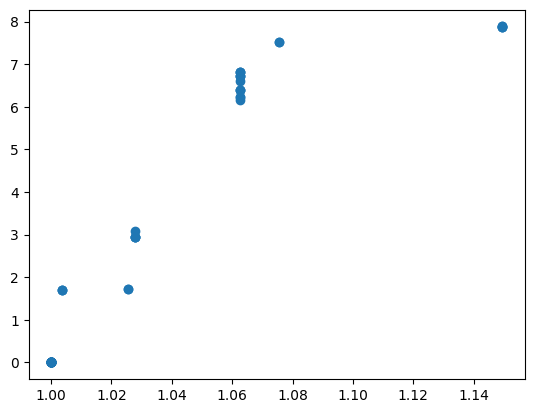

In [8]:
def normalize(L):
    return [l/min(L) for l in L]

# X = [s.objectives[0] for s in obj[1].get('SOLUTIONS')]
tail_jcts = [s.objectives[1] for s in obj[1].get('SOLUTIONS')]

# X_norm = [x/min(X) for x in X]
# Y_norm = [y/min(Y) for y in Y]
# Y_norm = Y

pred_error = Y

tail_jcts = normalize(tail_jcts)

plt.scatter(tail_jcts, pred_error, label="All Points")

# plt.xlabel(labels[0])
# plt.ylabel(labels[1])

plt.show()